# Model compression

Project: Embedded Artificial Intelligence for Radar-Based Presence Detection

Techniques tested:
- Post training quantisation (float32 inputs, int8 activations)
- Pruning
- Clustering
- Quantisation-aware training

Note: Comparing model sizes might not be accurate (confirmed for .tflite file since conversion to .cc results in increased size).

In [1]:
from typing import Dict, Any
import argparse
import yaml
import numpy as np
import tensorflow as tf
from toolbox.helper import load_yaml, tf_model_evaluate, get_gzipped_model_size

2023-07-24 17:34:02.398613: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 17:34:02.401229: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 17:34:02.453348: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 17:34:02.454199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 17:34:03.550398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
from typing import Dict, Any
import argparse
import logging
import sklearn
import matplotlib.pyplot as plt
import sklearn.metrics
import json
from sklearn.metrics import confusion_matrix, classification_report
# from callbacks import CustomCallback, MLH_Callback, ConfusedCallback
import seaborn as sns
import pandas as pd
import datetime
from IPython.display import clear_output
import tensorflow as tf
import yaml 
import os
import numpy as np
import pathlib
import tempfile
import zipfile

class Sequence(tf.keras.utils.Sequence):
    def __init__(self, parent_path, preprocess_func, batch_size=64, classification=False, l_count=4, seq_len=8, seq_step=1, test=False, reshape=False):
        self.preprocess_func = preprocess_func
        self.seq_len = seq_len
        self.seq_step = seq_step
        self.batch_size = batch_size
        self.reshape = reshape
        self.data, self.labels = self.load_raw_data(parent_path, classification=classification, test=test, l_count=l_count, sequence=seq_len)
        self.seq_lens = [s.shape[0] - int(seq_len * seq_step) for s in self.data]
        self.shuffler = np.random.permutation(np.array(self.seq_lens).sum())
    
    def __len__(self):
        return np.array(self.seq_lens).sum() // self.batch_size
    
    def get_dist(self):
        dist = {
            "0" : 0,
            "1" : 0,
            "2" : 0,
            "3" : 0,
            "4" : 0
        }
        
        for batch in self.labels:
            for l in batch:
                dist[str(l)] += 1
        
        return dist

    @classmethod
    def __generate_identifier(cls, parent_path, batch_size, classification, l_count, seq_len, seq_step, test, reshape):
        string = f"{parent_path}-{batch_size}-{classification}-{l_count}-{seq_len}-{seq_step}-{reshape}"
        identifier = hashlib.md5(string.encode()).hexdigest()

        timestamp = datetime.utcnow().strftime("%Y-%m-%d")
        config = "test" if test else "train"

        identifier = f"{identifier}_{test}_{timestamp}"
        return identifier

    def indices_to_recidx(self, indices):
        rec_indices = []
        k_list = []
        for idx in indices:
            k = 0
            for rec_len in self.seq_lens:
                if idx - rec_len >= 0:
                    idx = idx - rec_len
                    k += 1
                else:
                    rec_indices.append(idx)
                    k_list.append(k)
                    break
        return k_list, rec_indices

    def __getitem__(self, idx):
        data = []
        labels = []
        indices = self.shuffler[idx * self.batch_size:(idx + 1) * self.batch_size]
        if isinstance(self.labels, list):
            k_list, rec_indices = self.indices_to_recidx(indices)
        else:
            indices = np.random.randint(self.labels.shape[0], size=self.batch_size)
            return self.data[indices, ...], self.labels[indices]

        for i in range(self.batch_size):
            seq_indices = rec_indices[i] + np.arange(self.seq_len) * self.seq_step
            data.append(self.data[k_list[i]][seq_indices])
            if self.seq_len > 1:
                same_labels = np.all(self.labels[k_list[i]][seq_indices] == self.labels[k_list[i]][rec_indices[i]])
            else:
                same_labels = True
            if not same_labels:
                majority_label = np.sum(self.labels[k_list[i]][seq_indices], axis=0) // self.seq_len
                labels.append(majority_label)
            else:
                labels.append(self.labels[k_list[i]][rec_indices[i]])

        if self.reshape:
            new_shape = (16, 10, self.seq_len*8)
            for i, sample in enumerate(data):
                transposed_array = np.transpose(sample, (1, 2, 3, 0))
                data[i] = np.reshape(transposed_array, new_shape)
        
        if np.random.rand() > 0.5:
            return np.flip(np.stack(data, axis=0), axis=-2), np.stack(labels, axis=0)
        else:
            return np.stack(data, axis=0), np.stack(labels, axis=0)

    def on_epoch_end(self):
        np.random.shuffle(self.shuffler)
        
    def load_raw_data(self, parent_path, classification : bool = False, test : bool = False, l_count : int = 4, sequence : int = 1) -> tuple:
        if isinstance(parent_path, list):
            folder_list = []
            for p in parent_path:
                folders = list(map(lambda item: p + item, list(os.listdir(p))))
                folder_list = folder_list + folders
        else:
            folder_list = list(map(lambda item: parent_path + item, list(os.listdir(parent_path))))

        if test:
            folder_list = [f for f in folder_list if ('test' in f)]
        else:
            folder_list = [f for f in folder_list if not ('test' in f)]

        print(folder_list)

        data_list = []
        label_list = []

        count = 0
        bar_len = 20

        for folder in folder_list:
            rec_list = os.listdir(folder)  # List of filenames of files inside directory
    #         print(folder)
            label_rec_list = [r for r in rec_list if r.__contains__("label")]
            rec_list = [r for r in rec_list if
                        r.__contains__("radar") and not r.__contains__("label") and not r.__contains__("process")]
            num_files = len(rec_list)
            for i, rec in enumerate(rec_list):
                # print("rec: ", folder + '/' + rec)

                clear_output(wait=True)
                count += 1
                print("Directory: " + parent_path)
                print("Current file: " + rec)
                print("Progress: " + str(count) + "/" + str(num_files))

                data = np.load(folder + '/' + rec)
                # print("Data shape: " + data.shape)
                # print(f"raw data min: {np.amin(data)}, max {np.amax(data)} mean {np.mean(data)}")
                data_processed = self.preprocess_func(data / 4095.0, normalization=False)
                if "all_recs" in folder + rec:
                    #print("got labels :)")
                    label_rec_path = [l for l in label_rec_list if l.__contains__(rec[:-9])]
                    # print(rec, label_rec_path)
                    try:
                        labels = np.load(folder + "/" + label_rec_path[0])
                        labels = np.where(labels > 4, 4, labels)

                    except Exception as e:
                        print(e)
                        print(data.shape)
                        labels = np.load(folder + "/" + label_rec_path[0], allow_pickle=True)

                else:
                    count = int(rec[0])
                    labels = np.ones(data_processed.shape[0]) * count
                    labels = np.where(labels > 4, 4, labels)

                if classification:
                    labels[labels > (l_count - 1)] = l_count - 1
                    b = np.zeros((labels.size, l_count))
                    b[np.arange(labels.size), labels.astype(np.int)] = 1
                    labels = b
                # print(labels.shape[0], data_processed.shape[0])
                # print(f"label available {np.unique(labels)}")
                assert labels.shape[0] == data_processed.shape[0]
                ## Changes can be made here -Z
                label_list.append(labels)
                data_list.append(data_processed)
                assert len(label_list) == len(data_list)

        if sequence > 1:
            return data_list, label_list

        return np.concatenate(data_list, axis=0), np.concatenate(label_list, axis=0)


In [3]:
import numpy as np

def preprocess(data_in, chirp_count=16, num_samples=64, normalization=False):
    # normalization = True
    if normalization:
        data_in = (data_in - data_in.min(axis=(1, 2, 3), keepdims=True)) / (data_in.max(axis=(1, 2, 3), keepdims=True))
    data_out = []
    data_out_slow = []
    data_list = []
    for i_frame, data in enumerate(data_in):
        if i_frame < int(chirp_count):
            data_list.append(np.copy(data))  # divide by data.max()
        else:
            del data_list[0]
            data_list.append(np.copy(data.astype(np.float32)))
            # creating slow time data frame
            data_slow = np.stack(data_list, axis=0)
            data_slow = np.transpose(data_slow.mean(axis=2), [1, 0, 2])

            # remove means for MTI
            data = data - data.mean(axis=1, keepdims=True)
            data_slow = data_slow - data_slow.mean(axis=1, keepdims=True)

            # Do Range-Doppler processing
            # windowing
            data = data * (np.hamming(num_samples) * (np.hamming(chirp_count)[np.newaxis]).T[np.newaxis])
            data_slow = data_slow * (np.hamming(num_samples) * (np.hamming(chirp_count)[np.newaxis]).T[np.newaxis])

            # FFTs
            data = np.fft.fft2(data, axes=[2, 1])[..., :int(num_samples // 2)]
            data_slow = np.fft.fft2(data_slow, axes=[2, 1])[..., :int(num_samples // 2)]
            # FFT shifts
            data = np.fft.fftshift(data, axes=1)
            data_slow = np.fft.fftshift(data_slow, axes=1)
            data_out.append(data)
            data_out_slow.append(data_slow)

    # data_out[0].shape: (3, 16, 32)

    data = np.stack([np.real(data_out), np.imag(data_out), np.real(data_out_slow), np.imag(data_out_slow)], axis=-1)
    # data.shape:  (1185, 3, 16, 32, 4)
    macro = data[..., 0:2]
    micro = data[..., 2:4]
    macro = np.moveaxis(macro, 1, -2)
    # macro.shape: (1185, 16, 32, 3, 2)
    macro = macro.reshape((macro.shape[0], macro.shape[1], macro.shape[2], -1))
    micro = np.moveaxis(micro, 1, -2)
    # micro.shape: (1185, 16, 32, 3, 2)
    micro = micro.reshape((micro.shape[0], micro.shape[1], micro.shape[2], -1))
    # macro (1185, 16, 32, 6)
    # micro (1185, 16, 32, 6)
    data = np.concatenate([macro, micro], axis=-1)  # [16, 32, 12]

    # antenna 1: idx: [..., 0,1,6,7]
    # antenna 2: idx: [..., 2, 3, 8, 9]
    # antenna 3: idx: [..., 4, 5, 10, 11]

    """
    data = np.stack([np.abs(data_out), np.abs(data_out_slow)], axis=-1)
    data = data.reshape((-1, data.shape[-3], data.shape[-2], data.shape[-1]))
    data = data[:,:,:16,:]
    data = data/np.amax(data, axis=(1,2), keepdims=True)
    data[data<0.05]=0
    """
    data = data[:, :, :10, ...]
    if data.shape[-1] > 8:
        #return data[..., [0,1,4,5,6,7,10,11]].astype(np.float16)
        return data[..., [0,1,4,5,6,7,10,11]].astype(np.float32)

    #return data.astype(np.float16)

    return data.astype(np.float32)


In [26]:
import tensorflow as tf
import numpy as np
from typing import Optional
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_model_optimization as tfmot
# from .sequence_gen import Sequence
# from .helper import tf_model_evaluate

class Quantise:
    def __init__(self, model : tf.keras.Sequential, parameters : dict):
        self.model = None
        self.converter = tf.lite.TFLiteConverter.from_keras_model(model)
        self.converter.optimizations = [parameters["optimizations"]]
        self.converter.target_spec.supported_ops = [parameters["opset"]]
        if parameters["representative_dataset_gen"] is not None:
            self.converter.representative_dataset = self.__create_rep_datagen(parameters["representative_dataset_gen"])
        self.interpreter = None
        self.quant_type = "float32"
        
    def __create_rep_datagen(self, rep_seq : Sequence):
        def rep_datagen():
            for batch in rep_seq:
                for item in batch[0]:
                    shape = (1,) + item.shape
                    new_item = np.reshape(item.astype(np.float32), shape)
                    yield [new_item]
        return rep_datagen
            
    def convert(self):
        try:
            self.model = self.converter.convert()
        except:
            raise Exception("Conversion unsuccessful.")
            
    def save(self, filename : str, directory : str):
        if self.model is not None:
            with open(directory + filename, 'wb') as f:
                f.write(self.model)
        print("Saved to " + directory + filename)
                
    def evaluate(self, val_data : Sequence) -> dict: 
        if self.model is not None:
            if self.interpreter is None:
                self.interpreter = tf.lite.Interpreter(model_content=self.model)
                self.interpreter.allocate_tensors()

            input_tensor_index = self.interpreter.get_input_details()[0]["index"]
            output_tensor_index = self.interpreter.get_output_details()[0]["index"]

            preds = []
            trues = []
            pred_prob = []

            print("Evaluating .tflite model. Please wait...")

            for batch in val_data: #batch[0]: samples, batch[1]: labels
                data = batch[0]
                labels = batch[1]
                b_size = len(labels)

                for i in range(b_size):
                    inp = data[i]
                    shape = (1,) + inp.shape
                    inp = np.reshape(inp, shape)

                    y_true = labels[1]

                    inp = inp.astype(np.float32)

                    self.interpreter.set_tensor(input_tensor_index, inp)
                    self.interpreter.invoke()

                    y_pred = self.interpreter.get_tensor(output_tensor_index)
                    y_pred_class = np.argmax(y_pred, axis=-1)
                    pred_prob.append(np.amax(y_pred, axis=-1))
                    trues.append(y_true)
                    preds.append(y_pred_class)

            y_true = np.array(trues)
            y_pred_prob = np.array(pred_prob)
            y_pred = np.array(preds)
            report = classification_report(y_true=y_true, y_pred=y_pred, output_dict=True)

            return report
        else:
            raise Exception("Model not defined!")
            

class Prune:
    def __init__(self, model : tf.keras.Sequential, parameters : dict):
        prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
        self.batch_size = parameters["batch_size"]
        self.epochs = parameters["epochs"]
        self.train_data = parameters["train_sequence"]
        self.val_data = parameters["validation_sequence"]

        end_step = np.ceil(self.train_data.__len__() / self.batch_size).astype(np.int32) * self.epochs
        
        pruning_params = { 
            'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                     final_sparsity=0.80,
                                                                     begin_step=0,
                                                                     end_step=end_step)
        }
        
        self.model = prune_low_magnitude(model, **pruning_params)
        self.model_stripped = None
        self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
    def summary(self):
        return self.model.summary()
    
    def tune(self):
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep(),
        ]

        self.model.fit(self.train_data, validation_data=self.val_data,
                          batch_size=self.batch_size, epochs=self.epochs,
                          callbacks=callbacks)
        
        self.model_stripped = tfmot.sparsity.keras.strip_pruning(self.model)
        
    def save(self, filename : str, directory : str):
        # Strip pruning overhead
        if self.model_stripped is not None:
            print("Saving model (without pruning overhead) to: ", directory + filename)
            tf.keras.models.save_model(self.model_stripped, directory + filename, include_optimizer=False)
        else:
            print("Could not save. Train model first!")
        
    def evaluate(self):
        return tf_model_evaluate(self.model, self.val_data)
    
class ClusterWeights:
    def __init__(self, model : tf.keras.Sequential, parameters : dict):
        cluster_weights = tfmot.clustering.keras.cluster_weights
        CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
        self.train_data = parameters["train_sequence"]
        self.val_data = parameters["validation_sequence"]
        self.batch_size = parameters["batch_size"] # 500
        self.epochs = parameters["epochs"] # 1

        clustering_params = {
          'number_of_clusters': parameters["number_of_clusters"],
          'cluster_centroids_init': CentroidInitialization.LINEAR
        }
        
        self.model = cluster_weights(model, **clustering_params)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                           metrics=['accuracy'])
        
    def tune(self):
        self.model.fit(self.train_data, validation_data=self.val_data, batch_size=self.batch_size, epochs=self.epochs)
        self.model_stripped = tfmot.clustering.keras.strip_clustering(self.model)
        
    def summary(self):
        return self.model.summary()
    
    def save(self, filename : str, directory : str):
        # Strip clustering overhead
        if self.model_stripped is not None:
            print("Saving model (without clustering overhead) to: ", directory + filename)
            tf.keras.models.save_model(self.model_stripped, directory + filename, include_optimizer=False)
    
    def evaluate(self):
        return tf_model_evaluate(self.model, self.val_data)


# Generating and analysing datasets

Generate training dataset. The `sequence_gen` function loads the data and applies the preprocessing function.

In [5]:
config = load_yaml("default_config.yaml")
output_size = 5

In [6]:
train_data = Sequence(config['data_settings']['parent_path'], preprocess_func=preprocess,
                      classification=config['network_settings']['classification'], l_count=output_size, 
                      reshape=True)

Directory: /ifxhome/pplcount/data_antipeeking2/all_recs_1_5m_train/
Current file: TS-012022_09_20_15_29_24radar.npy
Progress: 188/188


Generate validation dataset.

In [7]:
val_data = Sequence(config['data_settings']['val_parent_path'], preprocess_func=preprocess,
                    classification=config['network_settings']['classification'], test=True,
                    l_count=output_size, reshape=True)

Directory: /ifxhome/pplcount/data_antipeeking2/all_recs_1_5m_test/
Current file: complex_2TS-102022_10_07_11_30_55radar.npy
Progress: 283/283


Text(0, 0.5, 'Number')

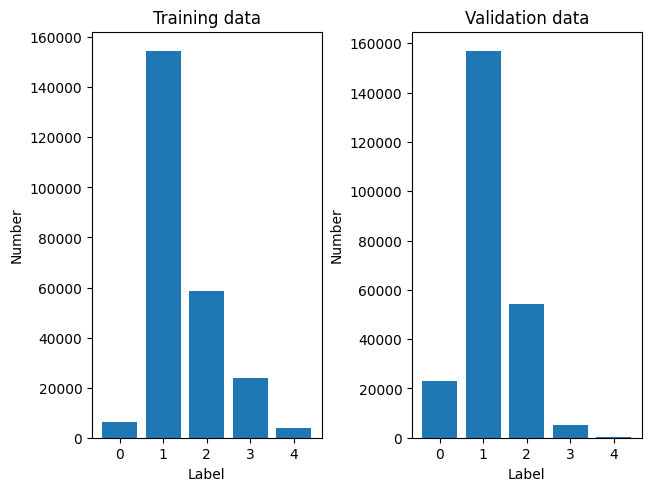

In [8]:
train_dist = train_data.get_dist()
val_dist = val_data.get_dist()
names = list(train_dist.keys())

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)

values = list(train_dist.values())
ax1.bar(names, values)
ax1.set_title("Training data")
ax1.set_xlabel("Label")
ax1.set_ylabel("Number")

values = list(val_dist.values())
ax2.bar(names, values)
ax2.set_title("Validation data")
ax2.set_xlabel("Label")
ax2.set_ylabel("Number")

# Defining and training a CNN-Based model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(16, 10, 64)),  # 64 is batch size
    tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=1, activation="relu"),
    tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(output_size)
])

model.summary()

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# model.fit(train_data.data, train_data.labels, validation_split=0.2, epochs=2, class_weight=class_weight)
model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10


2023-07-21 13:21:26.515601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3832/3832 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.7630

2023-07-21 13:23:03.919707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3832/3832 [==============================] - 132s 34ms/step - loss: 0.5891 - accuracy: 0.7630 - val_loss: 0.8882 - val_accuracy: 0.6988
Epoch 2/10
3832/3832 [==============================] - 130s 34ms/step - loss: 0.5164 - accuracy: 0.7893 - val_loss: 0.7379 - val_accuracy: 0.7191
Epoch 3/10
3832/3832 [==============================] - 131s 34ms/step - loss: 0.5037 - accuracy: 0.7925 - val_loss: 0.6302 - val_accuracy: 0.7693
Epoch 4/10
3832/3832 [==============================] - 131s 34ms/step - loss: 0.4942 - accuracy: 0.7965 - val_loss: 0.6162 - val_accuracy: 0.7422
Epoch 5/10
3832/3832 [==============================] - 130s 34ms/step - loss: 0.4882 - accuracy: 0.7974 - val_loss: 0.6365 - val_accuracy: 0.7428
Epoch 6/10
3832/3832 [==============================] - 131s 34ms/step - loss: 0.4803 - accuracy: 0.8004 - val_loss: 0.6935 - val_accuracy: 0.7412
Epoch 7/10
3832/3832 [==============================] - 133s 35ms/step - loss: 0.4753 - accuracy: 0.8024 - val_loss: 0.7037 - val

In [12]:
model_file = 'u_model_slim.h5'
model_file_opt = 'u_model_slim_opt.h5' # For finding compression factor
print('Saving model to: ', 'models/' + model_file)
tf.keras.models.save_model(model, 'models/' +
                           model_file, include_optimizer=False)
tf.keras.models.save_model(model, 'models/' +
                           model_file_opt)

Saving model to:  models/u_model_slim.h5


# Loading the uncompressed (basline) model

Required for analysing the compression techniques that follow.

In [10]:
u_model = tf.keras.models.load_model("models/u_model_slim.h5")
u_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwise  (None, 14, 8, 64)        640       
 Conv2D)                                                         
                                                                 
 conv2d (Conv2D)             (None, 12, 6, 4)          2308      
                                                                 
 batch_normalization (BatchN  (None, 12, 6, 4)         16        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 50)                14450     
                                                                 
 dense_1 (Dense)             (None, 5)                 2

In [11]:
u_model_metrics = tf_model_evaluate(u_model, val_data)


Progress: 3705/3705


In [12]:
u_model_size = get_gzipped_model_size("models/u_model_slim.h5")
print(str(u_model_size) + "KB")

68.976KB


# Post-training quantisation

In [ ]:
# from toolbox.tflite_helper import Quantised, Pruned, Clustered

Using model from this notebook

In [36]:
quant_params = {
    "optimizations" : tf.lite.Optimize.DEFAULT,
    "opset" : tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    "representative_dataset_gen" : val_data
}

q_model = Quantise(u_model, parameters=quant_params)
q_model.convert()

INFO:tensorflow:Assets written to: /tmp/tmpof0cs78m/assets


INFO:tensorflow:Assets written to: /tmp/tmpof0cs78m/assets
/home/radar_embed2/virtualenvs/venv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-07-24 10:44:24.080574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-24 10:44:24.080599: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-24 10:44:24.081297: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpof0cs78m
2023-07-24 10:44:24.082496: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-24 10:44:24.082514: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpof0cs78m
2023-07-24 10:44:24.086050: I tensorflow/compiler/

In [84]:
q_model.save("quant_test_slim_v2.tflite", "models/")

Saved to models/quant_test_slim_v2.tflite


In [74]:
q_model_metrics = q_model.evaluate(val_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Evaluating .tflite model. Please wait...


In [75]:
# Evaluate model sizes
q_model_size = get_gzipped_model_size("models/quant_test_slim.tflite")
print("Uncompressed model size: ", u_model_size, ' KB')
print("Quantised model size: ", q_model_size, ' KB')

# Print results
print('Uncompressed model validation accuracy (%):', u_model_metrics['accuracy'] * 100)
print('Quantised model validation accuracy (%):', q_model_metrics['accuracy'] * 100)
print("Accuracy loss (%):", (u_model_metrics['accuracy'] - q_model_metrics['accuracy']) * 100)
print("Compression factor:", u_model_size/q_model_size)

Uncompressed model size:  68.976  KB
Quantised model size:  17.416  KB
Uncompressed model validation accuracy (%): 75.47106950067476
Quantised model validation accuracy (%): 60.54107624831309
Accuracy loss (%): 14.929993252361673
Compression factor: 3.960496095544327


In [25]:
# Convert .tflite file to a C array
!xxd -i models/quant_test_slim.tflite > quant_test_slim.cc

In [ ]:
# import tinymlgen as tg
# c_code = tg.port(quant_model, pretty_print=True)

# Pruning

In [37]:
!pip install tensorflow_model_optimization

Defaulting to user installation because normal site-packages is not writeable


In [13]:
pruning_params = {
    "batch_size" : 64,
    "epochs" : 2,
    "train_sequence" : train_data,
    "validation_sequence" : val_data
}

p_model = Prune(u_model, parameters=pruning_params)
p_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_depthwi  (None, 14, 8, 64)        641       
 se_conv2d (PruneLowMagnitud                                     
 e)                                                              
                                                                 
 prune_low_magnitude_conv2d   (None, 12, 6, 4)         4614      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_batch_n  (None, 12, 6, 4)         17        
 ormalization (PruneLowMagni                                     
 tude)                                                           
                                                                 
 prune_low_magnitude_flatten  (None, 288)              1         
  (PruneLowMagnitude)                                   

In [14]:
p_model.tune()

Epoch 1/2


2023-07-24 17:50:32.388834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3828/3832 [============================>.] - ETA: 0s - loss: 0.5359 - accuracy: 0.7765

2023-07-24 17:51:20.431465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3832/3832 [==============================] - 76s 19ms/step - loss: 0.5359 - accuracy: 0.7766 - val_loss: 0.6182 - val_accuracy: 0.7438
Epoch 2/2
3832/3832 [==============================] - 73s 19ms/step - loss: 0.5132 - accuracy: 0.7885 - val_loss: 0.6057 - val_accuracy: 0.7596


In [15]:
p_model.save("pruned_model.h5", "models/")

Saving model (without pruning overhead) to:  models/pruned_model.h5


In [16]:
p_model_metrics = p_model.evaluate()

Progress: 3705/3705


In [17]:
# Evaluate model sizes
u_model_size = get_gzipped_model_size("models/u_model_slim.h5")
p_model_size = get_gzipped_model_size("models/pruned_model.h5")
print("Uncompressed model size: ", u_model_size, ' KB')
print("Pruned model size: ", p_model_size, ' KB')

# Print results
print('Uncompressed model validation accuracy (%):', u_model_metrics['accuracy'] * 100)
print('Pruned model validation accuracy (%):', p_model_metrics['accuracy'] * 100)
print("Accuracy loss (%):", (u_model_metrics['accuracy'] - p_model_metrics['accuracy']) * 100)
print("Compression factor:", u_model_size/p_model_size)

Uncompressed model size:  68.976  KB
Pruned model size:  26.074  KB
Uncompressed model validation accuracy (%): 75.42594466936572
Pruned model validation accuracy (%): 75.96997300944669
Accuracy loss (%): -0.5440283400809709
Compression factor: 2.6453938789598834


**Quantising pruned model**

In [20]:
quant_params = {
    "optimizations" : tf.lite.Optimize.DEFAULT,
    "opset" : tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    "representative_dataset_gen" : val_data
}

q2_model = Quantise(p_model.model_stripped, parameters=quant_params)
q2_model.convert()

INFO:tensorflow:Assets written to: /tmp/tmpjscvfawz/assets


INFO:tensorflow:Assets written to: /tmp/tmpjscvfawz/assets
/home/radar_embed2/virtualenvs/venv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-07-24 17:57:01.901432: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-24 17:57:01.901464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-24 17:57:01.901799: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjscvfawz
2023-07-24 17:57:01.902969: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-24 17:57:01.902987: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjscvfawz
2023-07-24 17:57:01.906434: I tensorflow/compiler/

In [21]:
q2_model.save("quant_test_slim_pruned.tflite", "models/")

Saved to models/quant_test_slim_pruned.tflite


In [22]:
q2_model_metrics = q2_model.evaluate(val_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Evaluating .tflite model. Please wait...


In [23]:
# Evaluate model sizes
q2_model_size = get_gzipped_model_size("models/quant_test_slim_pruned.tflite")
print("Uncompressed model size: ", u_model_size, ' KB')
print("Quantised model size: ", q2_model_size, ' KB')

# Print results
print('Uncompressed model validation accuracy (%):', u_model_metrics['accuracy'] * 100)
print('Quantised model validation accuracy (%):', q2_model_metrics['accuracy'] * 100)
print("Accuracy loss (%):", (u_model_metrics['accuracy'] - q2_model_metrics['accuracy']) * 100)
print("Compression factor:", u_model_size/q2_model_size)

Uncompressed model size:  68.976  KB
Quantised model size:  9.325  KB
Uncompressed model validation accuracy (%): 75.42594466936572
Quantised model validation accuracy (%): 62.24612010796221
Accuracy loss (%): 13.179824561403509
Compression factor: 7.396890080428955


# Clustering

In [27]:
clustering_params = {
    "batch_size" : 500,
    "epochs" : 1,
    "number_of_clusters": 16,
    "train_sequence" : train_data,
    "validation_sequence" : val_data
}

c_model = ClusterWeights(u_model, parameters=clustering_params)
c_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_depthwise_conv2d (C  (None, 14, 8, 64)        640       
 lusterWeights)                                                  
                                                                 
 cluster_conv2d (ClusterWeig  (None, 12, 6, 4)         4628      
 hts)                                                            
                                                                 
 cluster_batch_normalization  (None, 12, 6, 4)         16        
  (ClusterWeights)                                               
                                                                 
 cluster_flatten (ClusterWei  (None, 288)              0         
 ghts)                                                           
                                                                 
 cluster_dense (ClusterWeigh  (None, 50)               2

In [28]:
c_model.tune()

2023-07-24 19:10:30.037724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3828/3832 [============================>.] - ETA: 0s - loss: 0.9025 - accuracy: 0.6668

2023-07-24 19:11:21.313278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3832/3832 [==============================] - 82s 21ms/step - loss: 0.9022 - accuracy: 0.6669 - val_loss: 0.6663 - val_accuracy: 0.7234


In [30]:
c_model.save("clustered_model.h5", "models/")

Saving model (without clustering overhead) to:  models/clustered_model.h5


In [31]:
c_model_metrics = p_model.evaluate()

Progress: 3705/3705


In [32]:
# Evaluate model sizes
u_model_size = get_gzipped_model_size("models/u_model_slim.h5")
c_model_size = get_gzipped_model_size("models/clustered_model.h5")
print("Uncompressed model size: ", u_model_size, ' KB')
print("Pruned model size: ", c_model_size, ' KB')

# Print results
print('Uncompressed model validation accuracy (%):', u_model_metrics['accuracy'] * 100)
print('Pruned model validation accuracy (%):', c_model_metrics['accuracy'] * 100)
print("Accuracy loss (%):", (u_model_metrics['accuracy'] - c_model_metrics['accuracy']) * 100)
print("Compression factor:", u_model_size/c_model_size)

Uncompressed model size:  68.976  KB
Pruned model size:  11.48  KB
Uncompressed model validation accuracy (%): 75.42594466936572
Pruned model validation accuracy (%): 69.90932860998652
Accuracy loss (%): 5.516616059379209
Compression factor: 6.008362369337979


**Quantising clustered model**

In [33]:
quant_params = {
    "optimizations" : tf.lite.Optimize.DEFAULT,
    "opset" : tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    "representative_dataset_gen" : val_data
}

q3_model = Quantise(c_model.model_stripped, parameters=quant_params)
q3_model.convert()

INFO:tensorflow:Assets written to: /tmp/tmpu_tlk_6f/assets


INFO:tensorflow:Assets written to: /tmp/tmpu_tlk_6f/assets
/home/radar_embed2/virtualenvs/venv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-07-24 19:15:14.741822: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-24 19:15:14.741847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-24 19:15:14.742030: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu_tlk_6f
2023-07-24 19:15:14.744607: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-24 19:15:14.744626: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu_tlk_6f
2023-07-24 19:15:14.754637: I tensorflow/cc/saved_

In [34]:
q3_model.save("quant_test_slim_clustered.tflite", "models/")

Saved to models/quant_test_slim_clustered.tflite


In [35]:
q3_model_metrics = q3_model.evaluate(val_data)

Evaluating .tflite model. Please wait...


In [36]:
# Evaluate model sizes
q3_model_size = get_gzipped_model_size("models/quant_test_slim_clustered.tflite")
print("Uncompressed model size: ", u_model_size, ' KB')
print("Quantised model size: ", q3_model_size, ' KB')

# Print results
print('Uncompressed model validation accuracy (%):', u_model_metrics['accuracy'] * 100)
print('Quantised model validation accuracy (%):', q3_model_metrics['accuracy'] * 100)
print("Accuracy loss (%):", (u_model_metrics['accuracy'] - q3_model_metrics['accuracy']) * 100)
print("Compression factor:", u_model_size/q3_model_size)

Uncompressed model size:  68.976  KB
Quantised model size:  7.51  KB
Uncompressed model validation accuracy (%): 75.42594466936572
Quantised model validation accuracy (%): 62.450657894736835
Accuracy loss (%): 12.97528677462888
Compression factor: 9.184553928095871
